In [2]:
#ruff: noqa
import numpy as np
from matplotlib import pyplot as plt
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy.interpolate import RectBivariateSpline

# Styling for the plots
fig_params = {"figsize": (7.5, 5)}
streamplot_params = {
    "color": "white",
    "density": 1,
    "linewidth": 0.25,
    "arrowsize": 0.5,
    "arrowstyle": "->",
}
scatter_params = {"s": 5}
font = {"family": "monospace", "size": 12}

---

# Interpolate class

In [3]:
class Interpolator:
    def __init__(self, dataset, fw=0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array(
            [(t - dataset.time[0]) / np.timedelta64(1, "s") for t in d.time[:]],
            dtype=np.float64,
        )
        self.depth = np.array(self.dataset.h)

    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0, :])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0, :])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1, :])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1, :])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(
            self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current
        )
        fv_current = RectBivariateSpline(
            self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current
        )
        fu_wind = RectBivariateSpline(
            self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind
        )
        fv_wind = RectBivariateSpline(
            self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind
        )
        return fu_current, fv_current, fu_wind, fv_wind

    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side="right") - 1

    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0, :])
        iy_list = np.searchsorted(self.dataset.Y, X[1, :])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy, ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0, :], X[1, :], grid=False) + self.fw * fu_wind(
            X[0, :], X[1, :], grid=False
        )
        dy = fv_current(X[0, :], X[1, :], grid=False) + self.fw * fv_wind(
            X[0, :], X[1, :], grid=False
        )
        return np.array([dx, dy])

---

# Trajectory class

In [4]:
class Trajectory:
    def __init__(
        self,
        x0=None,
        T=(0, 10),
        dt=0.01,
        Np=10,
        mode="map",
        loc=(0, 0),
        scale=1,
        check_land=False,
    ):
        self.dt = dt
        self.T = T
        self.Np = Np
        self.mode = mode
        self.l0, self.l1 = loc
        self.scale = scale
        self.check_land = check_land
        self.transform = None
        if x0 is not None:
            self.Np = x0.shape[1]
            self.x0 = x0
        else:
            self.x0 = np.zeros((2, Np))
            self.initialize_particles(mode)

    def __call__(self, func, method="heun"):
        self.func = func
        if method == "heun":
            return self.solve(func, method)
        else:
            raise ValueError("Unsupported method")

    def initialize_particles(self, mode):
        if mode == "map":
            self.x0[0, :] = np.random.normal(
                loc=self.l0, scale=self.scale, size=self.Np
            )
            self.x0[1, :] = np.random.normal(
                loc=self.l1, scale=self.scale, size=self.Np
            )

        elif mode == "linear_grid":
            self.x0[0, :] = np.linspace(self.l0, self.l1, self.Np)
            self.x0[1, :] = np.linspace(self.l0, self.l1, self.Np)
        elif mode == "grid":
            n = int(np.sqrt(self.Np))
            x = np.linspace(self.l0, self.l1, n)
            y = np.linspace(self.l0, self.l1, n)
            Xgrid, Ygrid = np.meshgrid(x, y)
            self.Xgrid, self.Ygrid = Xgrid, Ygrid
            self.x0[0, :] = Xgrid.flatten()
            self.x0[1, :] = Ygrid.flatten()

        else:
            raise ValueError("Invalid initialization mode")

    def heun_method(self, func, x0):
        ti, tf = self.T
        tn = int(np.ceil((tf - ti) / self.dt))

        Y = np.zeros((tn, 2, x0.shape[1]))
        V = np.zeros((tn, 2, x0.shape[1]))
        land_percent = np.array([])
        land = np.zeros(x0.shape[1], dtype=bool)
        Y[0] = x0
        t = ti
        for i in range(tn - 1):
            X = Y[i]

            k1 = func(X, t)
            X_temp = X + k1 * self.dt
            k2 = func(X_temp, t + self.dt)

            if self.check_land:
                land_mask = func.on_land(X)
                land |= land_mask

            k1[:, land] = 0
            k2[:, land] = 0
            np.append(land_percent, np.sum(land))

            Y[i + 1] = X + 0.5 * self.dt * (k1 + k2)
            V[i + 1] = 0.5 * (k1 + k2)
            t += self.dt

        self.L = Y[-1, :, land]
        self.land_percent = land_percent / x0.shape[1] * 100
        self.V = V
        return Y

    def solve(self, func, method="heun"):
        if method == "heun":
            self.solution = self.heun_method(func, self.x0)
            return self.solution
        else:
            raise ValueError("Unsupported method")

    def get_solution(self):
        return self.solution

    def get_velocity(self):
        return self.V

    def get_XY(self):
        X = self.solution[:, 0, :]
        Y = self.solution[:, 1, :]
        return X, Y

    def get_XY_grid(self):
        return self.Xgrid, self.Ygrid

    def get_UV(self):
        U = self.V[:, 0, :]
        V = self.V[:, 1, :]
        return U, V

    def get_land_particles(self):
        LX, LY = self.L.T
        return LX, LY

    def get_land_percent(self):
        return self.land_percent

    def plot(self, ax=None, **kwargs):
        if ax is None:
            fig, ax = plt.subplots()

        X, Y = self.get_XY()
        if self.transform is not None:
            ax.plot(X, Y, transform=self.transform, **kwargs)
        else:
            ax.plot(X, Y, **kwargs)
        ax.set_aspect("equal")
        return ax

    def scatter(self, ax=None, t=0,label='',**kwargs):
        X, Y = self.get_XY()
        if ax is None:
            fig, ax = plt.subplots()
        if self.transform is not None:
            ax.scatter(X[t, :], Y[t, :], transform=self.transform, **kwargs)
            if self.check_land:
                LX, LY = self.get_land_particles()
                ax.scatter(LX[:], LY[:], transform=self.transform, color="red", marker="x", s=25)        
        else:
            ax.scatter(X[t, :], Y[t, :], **kwargs)
        return ax

    def streamplot(self, ax=None, **kwargs):
        X, Y = self.get_XY()
        U, V = self.get_UV()
        if ax is None:
            fig, ax = plt.subplots()
        if self.transform is not None:
            ax.streamplot(X, Y, U, V, transform=self.transform, **kwargs)
        else:
            ax.streamplot(X, Y, U, V, **kwargs)
        return ax

    def init_map(self, ax=None, figsize=(10, 10), **kwargs):
        X, Y = self.get_XY()
        U, V = self.get_UV()
        if ax is None:
            fig = plt.figure(figsize=figsize)
            ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(
            cfeature.NaturalEarthFeature(
                "physical", "land", "10m", edgecolor="face", facecolor="#cccccc"
            )
        )
        ax.coastlines(resolution="10m")
        ax.gridlines(
            draw_labels=True,
            dms=True,
            x_inline=False,
            y_inline=False,
            alpha=0.5,
            color="k",
            lw=0.5,
        )
        projection_params = {
            "central_latitude": 90,
            "central_longitude": self.func.dataset.projection_stere.straight_vertical_longitude_from_pole,
            "false_easting": self.func.dataset.projection_stere.false_easting,
            "false_northing": self.func.dataset.projection_stere.false_northing,
            "true_scale_latitude": self.func.dataset.projection_stere.standard_parallel,
        }
        npstere = ccrs.Stereographic(**projection_params)
        ax.plot(X, Y, transform=npstere, **kwargs)
        ax.set_extent(ax.get_extent(crs=ccrs.PlateCarree()), crs=ccrs.PlateCarree())
        ax.gridlines(
            draw_labels=True,
            dms=True,
            x_inline=False,
            y_inline=False,
            alpha=0.5,
            color="k",
            lw=0.5,
        )
        ax.coastlines(resolution="10m")
        self.transform = npstere
        return ax

# Utilities

In [5]:
def velocity(X, t):
    A, eps, w = 0.10, 0.25, 1  # Initial constants
    a = eps * np.sin(w * t)  # Equation 4a
    b = 1 - 2 * eps * np.sin(w * t)
    x, y = X  # Assuming X is a 2-element array or has shape (2, N)
    f = a * x**2 + b * x  # Equation 4b
    dx = -np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * y)  # Equation 3
    dy = np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * y) * (2 * a * x + b)
    return np.array([dx, dy])


def plot(Y, alpha=0.1, linewidth=0.1, s=1, save=False, filename="trajectory.png"):
    plt.figure(figsize=(10, 10))
    plt.scatter(Y[0, 0, :], Y[0, 1, :], c="red", label="Initial Position", s=s)
    plt.scatter(Y[-1, 0, :], Y[-1, 1, :], c="blue", label="Final Position", s=s)
    plt.plot(Y[:, 0, :], Y[:, 1, :], alpha=alpha, linewidth=linewidth)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()


def run_steplength_test(
    func,
    ax,
    x0=np.array([[0], [0]]),
    T_values=[50, 100, 200],
    dt_values=[1, 0.1, 0.01, 0.001],
    **kwargs,
):
    time_array = np.zeros((len(T_values),len(dt_values)))
    for i, tf in enumerate(T_values):
        for j, dt in enumerate(dt_values):
            traj = Trajectory(x0=x0, T=(0, tf), dt=dt)
            init_time = time.time()
            X = traj(func)
            diff_time = time.time() - init_time
            time_array[i,j] = diff_time
            ax[i].plot(X[:, 0, :], X[:, 1, :], label=f"dt = {dt}", **kwargs)
        ax[i].set_title(f"T = {tf}", fontsize=10, family="monospace")
    return ax, time_array


def run_timing_test(func, T=[0, 10], Np_values=[1, 100, 1000, 10000, 10000], dt=0.01):
    plt.figure(figsize=(7.5, 5))
    times = []
    for Np in Np_values:
        x0 = np.random.rand(2, Np)
        start_time = time.time()
        traj = Trajectory(x0, T=T, dt=dt, Np=Np)
        traj(func)
        end_time = time.time()
        times.append(end_time - start_time)

    linear_times = [Np * (times[0] / Np_values[0]) for Np in Np_values]
    return times, linear_times


def plot_normal(
    f,
    X,
    V,
    L=None,
    figsize=(15, 12),
    pl_alp=0.1,
    sc_s=2,
    str_lw=1,
    pl_lw=0.1,
    str_dns=1,
    sc_col0="blue",
    sc_col1="red",
    pl_col="lightblue",
    sc_colL="purple",
    str_col="black",
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        X[:, 0, :],
        X[:, 1, :],
        color=pl_col,
        linewidth=pl_lw,
        alpha=pl_alp,
    )
    # Plot initial and final positions
    ax.scatter(
        X[0, 0, :],
        X[0, 1, :],
        s=sc_s,
        label="Initial positions",
        color=sc_col0,
    )
    ax.scatter(
        X[-1, 0, :],
        X[-1, 1, :],
        s=sc_s,
        label="Final positions",
        color=sc_col1,
    )
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()


def plot_map(
    f,
    X,
    V,
    L=None,
    figsize=(15, 12),
    extent=(7, 11, 63.5, 65),
    pl_alp=0.1,
    sc_s=2,
    str_lw=1,
    pl_lw=0.1,
    str_dns=1,
    sc_col0="blue",
    sc_col1="red",
    pl_col="lightblue",
    sc_colL="purple",
    str_col="black",
):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.contourf(
        X[0, :], X[1, :], V[0, :], cmap="coolwarm", transform=ccrs.PlateCarree()
    )
    # Adding land feature
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "physical", "land", "10m", edgecolor="face", facecolor="#cccccc"
        )
    )

    # Projection object for converting particle positions
    projection_params = {
        "central_latitude": 90,
        "central_longitude": f.dataset.projection_stere.straight_vertical_longitude_from_pole,
        "false_easting": f.dataset.projection_stere.false_easting,
        "false_northing": f.dataset.projection_stere.false_northing,
        "true_scale_latitude": f.dataset.projection_stere.standard_parallel,
    }
    npstere = ccrs.Stereographic(**projection_params)

    ax.plot(
        X[:, 0, :],
        X[:, 1, :],
        transform=npstere,
        color=pl_col,
        linewidth=pl_lw,
        alpha=pl_alp,
    )

    ax.streamplot(
        X[:, 0, :],
        X[:, 1, :],
        V[:, 0, :],
        V[:, 1, :],
        transform=npstere,
        color=str_col,
        linewidth=str_lw,
        density=str_dns,
        arrowstyle="->",
        arrowsize=1,
    )
    # Plot initial and final positions
    ax.scatter(
        X[0, 0, :],
        X[0, 1, :],
        transform=npstere,
        s=sc_s,
        label="Initial positions",
        color=sc_col0,
    )
    ax.scatter(
        X[-1, 0, :],
        X[-1, 1, :],
        transform=npstere,
        s=sc_s,
        label="Final positions",
        color=sc_col1,
    )
    if L is not None:
        ax.scatter(
            L[0, :],
            L[1, :],
            transform=npstere,
            s=3 * sc_s,
            label="Final positions",
            color=sc_colL,
        )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.gridlines(
        draw_labels=True,
        dms=True,
        x_inline=False,
        y_inline=False,
        alpha=0.5,
        color="k",
        lw=0.5,
    )

    ax.legend()
    plt.tight_layout()
    plt.show()

---

# Assignment

# Problem 1


## ( 1-a )
- We will first consider a single particle starting from an initial position $x_0 = [1.05,0.5]$. 
- Let the trajectory, x(t), of the particle be controlled by Eqs. (3) and (4). Calculate the trajectory for the time interval $ t_1 \in [0, 50]$,  using Heun’s method.
- Try a few different timesteps, and compare the results by plotting the trajectories for different timesteps in the same plot. Make up your mind about what seems a reasonably short timestep. 
- What happens if you double the integration time, such that $ t_2 \in [0, 100]$, is the same timestep still a good choice?



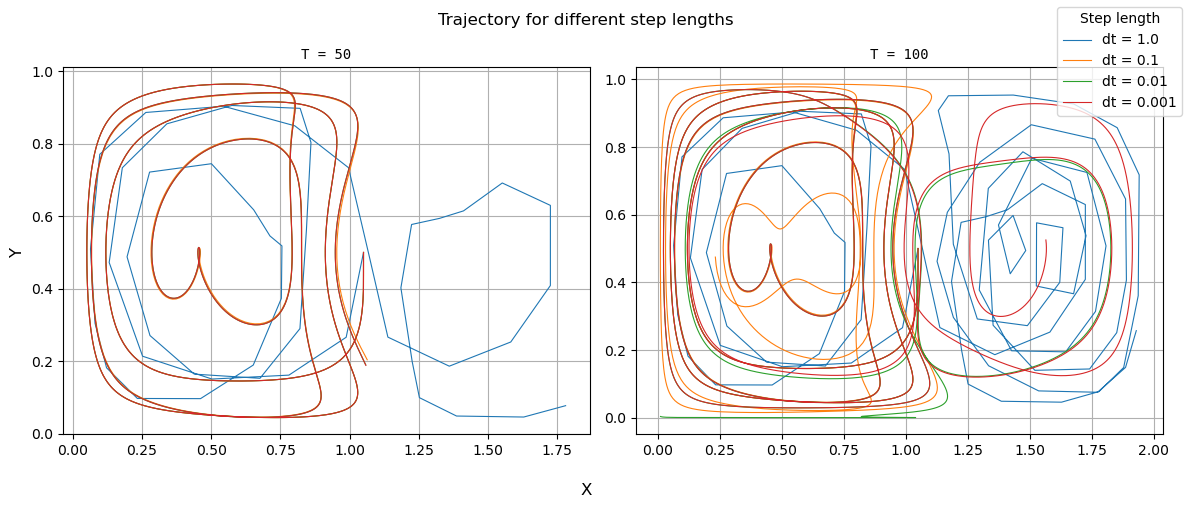

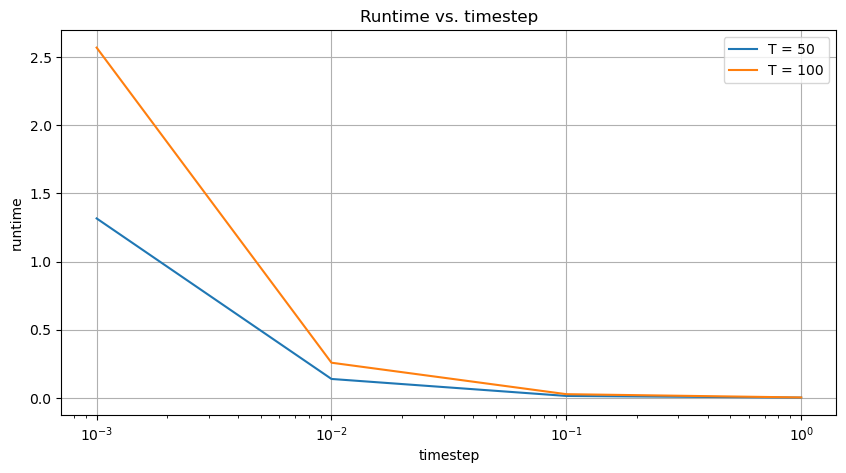

In [6]:
import time

fig_params = {"figsize": (7.5, 5)}
streamplot_params = {
    "color": "seagreen",
    "density": 1,
    "linewidth": 0.25,
    "arrowsize": 1,
    "arrowstyle": "->",
}
scatter_params = {"s": 5}
plot_params = {"alpha":1, "linewidth":0.8}

x0 = np.array([[1.05], [0.50]])
T_values = [50, 100]
dt_values = np.array([1, 0.1, 0.01, 0.001])

fig, ax = plt.subplots(1, len(T_values), figsize=(12, 5))
ax, time_array = run_steplength_test(
    velocity, ax, x0=x0, T_values=T_values, dt_values=dt_values, **plot_params
)
fig.suptitle("Trajectory for different step lengths")
fig.supxlabel("X")
fig.supylabel("Y")
fig.legend(*ax[0].get_legend_handles_labels(), loc="upper right", title="Step length")
ax[0].grid()
ax[1].grid()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dt_values, time_array[0, :], label="T = 50")
ax.plot(dt_values, time_array[1, :], label="T = 100")

ax.set_xscale("log")
ax.set_title("Runtime vs. timestep")
ax.set_xlabel("timestep")
ax.set_ylabel("runtime")
ax.grid()
ax.legend()
plt.show()

T:    50     dt:   1.0    
T:    50     dt:   0.1    
T:    50     dt:   0.01   
T:    50     dt:  0.001   
(4,)
T:   100     dt:   1.0    
T:   100     dt:   0.1    
T:   100     dt:   0.01   
T:   100     dt:  0.001   
(4,)


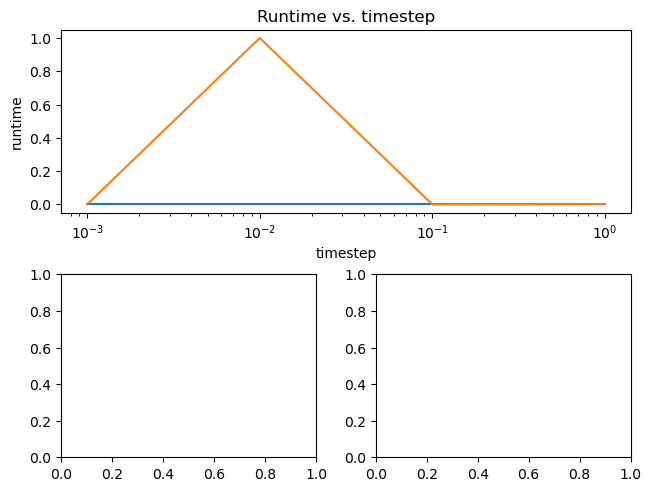

In [7]:
import time

x0 = np.array([[1.05], [0.50]])
T_values = np.array([50, 100])
dt_values = np.array([1, 0.1, 0.01, 0.001])


figd, axd = plt.subplot_mosaic(
    [["top", "top"], ["left", "right"]], constrained_layout=True
)

x0 = np.array([[1.05], [0.50]])


for tf in T_values:
    t_array = np.empty((len(dt_values)))
    for dt in dt_values:
        print(f'T:{tf:^10} dt:{dt:^10}')
        test_traj = Trajectory(x0,(0,tf),dt,Np=100)
        tik = time.time()
        test_traj(velocity, 'heun')
        tok = time.time()
        np.append(t_array, tik-tok)
    print(t_array.shape)
    axd['top'].plot(dt_values, t_array)
    axd['top'].set_xscale("log")
    axd['top'].set_title("Runtime vs. timestep")
    axd['top'].set_xlabel("timestep")
    axd['top'].set_ylabel("runtime")
plt.show()

For the first time interval $t \in [0, 50]$, the time-step $t = 0.1$ seems to be suffiecient to represent the particle.
For the time interval $t \in [0, 100]$, $t = 0.1$ deviates more from the shorter time steps, and is not short enough to represent the particle path correctly. With $t = 0.01$ however, is a better approximation, when comparing to the smaller timestep. 

Regarding the runtime, the biggest reduction happens when increasing $dt$ from 0.001 to 0.01. The graph shows a double in runtime when the time interval doubles, i.e. runtime is proportional to array length when using numpy arrays. For the time intervals tested here, the length of the arrays is not long enough for $dt$ to have a remarkable impact on runtime. For calculations going over several days, which will be the case later in the rapport, $dt$ will have to be significantly bigger.

Due to the significant reduction in runtime, $t = 0.01$ is the most economic timestep for these calculations.


## ( 1-b )

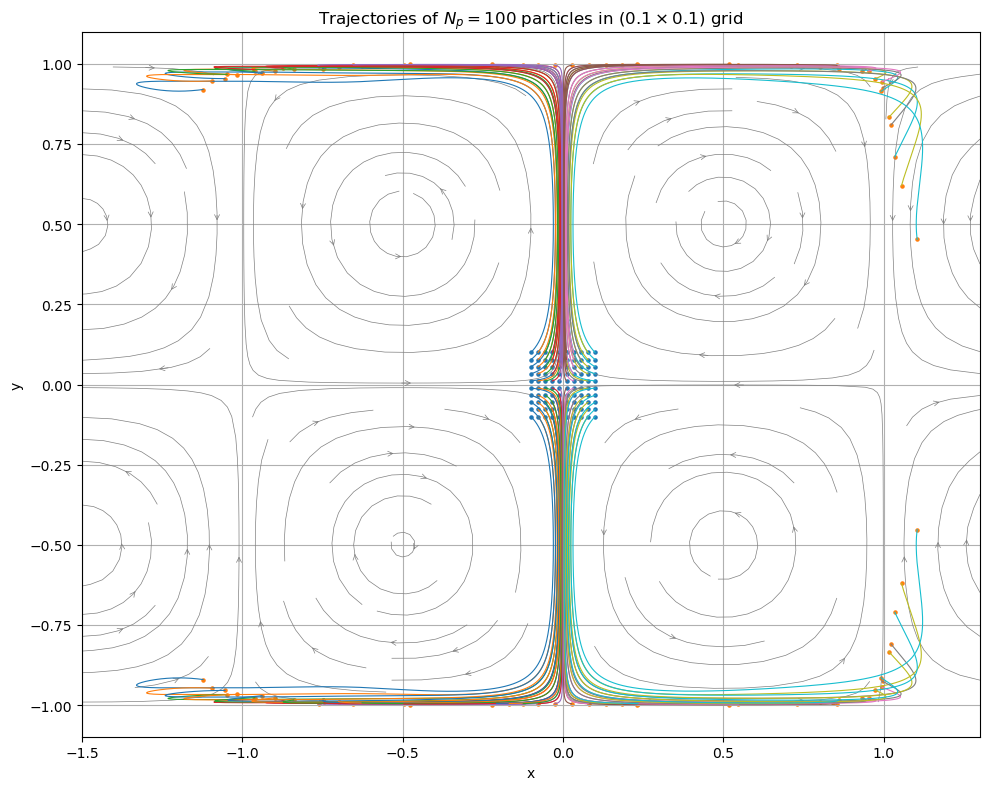

In [8]:
fig_params = {"figsize": (7.5, 5)}
streamplot_params = {
    "color": "grey",
    "density": 1,
    "linewidth": 0.25,
    "arrowsize": 1,
    "arrowstyle": "->",
}
scatter_params = {"s": 5}
plot_params = {"alpha":1, "linewidth":0.8}


T = [0, 10]
dt = 0.001
Np = 100
mode = "grid"
loc = [-0.1, 0.1]
scale = 0.1
fig, ax = plt.subplots(1,1, figsize=(10, 10))
traj = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale)
Y = traj(velocity)
X, Y = np.meshgrid(np.linspace(-1.5,1.3, 100), np.linspace(-0.99, 0.99, 100))
U, V = velocity([X, Y], 0)
ax.streamplot(X, Y, U, V, **{"color": "gray", "density": 1, "linewidth": 0.5, "arrowsize": 0.9, "arrowstyle": "->"})
traj.plot(ax, **plot_params)
traj.scatter(ax, t=0, **scatter_params)
traj.scatter(ax, t=-1, **scatter_params)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Trajectories of $N_p = 100$ particles in $(0.1\\times 0.1)$ grid")
plt.grid()
plt.tight_layout()
plt.show()

Depending on the initial position of each particle, here only separated by a distance of 0.01 units, takes different paths. The time interval is here limited to $t \in [0, 10]$ The streamlines represent the velocity field at $t=0$ to give an idea of the impact of the current and wind. This will change with time, but keeps somewhat the same shape. The particles on the further right are caught by the streams to the right, and similarly on the left side. 

## ( 1-c )


<Figure size 750x500 with 0 Axes>

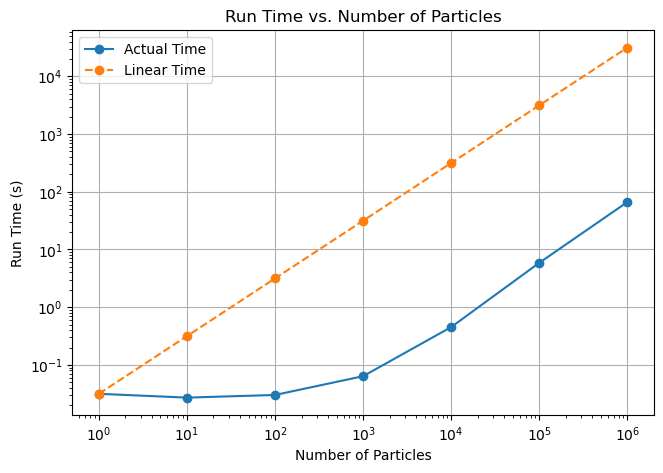

In [9]:
dt = 0.01
T = [0, 10]
Np_values = [1, 10, 100, 1000, 10_000,100_000, 1_000_000]
times, linear_times, = run_timing_test(velocity, T=T, Np_values=Np_values, dt=0.01)

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(Np_values, times, marker="o", label="Actual Time")
ax.plot(Np_values, linear_times, marker="o", linestyle="--", label="Linear Time")
ax.set_title("Run Time vs. Number of Particles")
ax.set_xlabel("Number of Particles")
ax.set_ylabel("Run Time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.grid(True)
plt.show()


The graph shows the curve is approximately constant for fewer particles, i.e. shorter arrays. For few particles, the linear increase may be too little to measure. The overhead time, in this case, is the time that python and jupyter cell/kernel uses as preparation for executing the task at hand. This overhead time can be few milliseconds, meaning if the running time of the numerical calculations are much smaller than the overhead time, there are no noticable variations between runtimes before it reaches a certain threshold. Here, this threshold seems to be reached when there are over 100 particles.

Another possible explanation for the constant runtime is how numpy allocates memory. For smaller array-sizes the compiler may overestimate how much memory needs to be allocated to avoid asking for new memory for every inceased index. Adding elements threrfore doesn't require additional runtime, resulting in constant time $\mathcal{O}(1)$. For bigger array-sizes, Python needs to allocate memory more frequently, resulting in a linear increase of runtime $\mathcal{O}(n)$.


---


# Problem 2


## ( 2-a )

$\hat{x} = 790.000$ og $\hat{y} = 490.000$


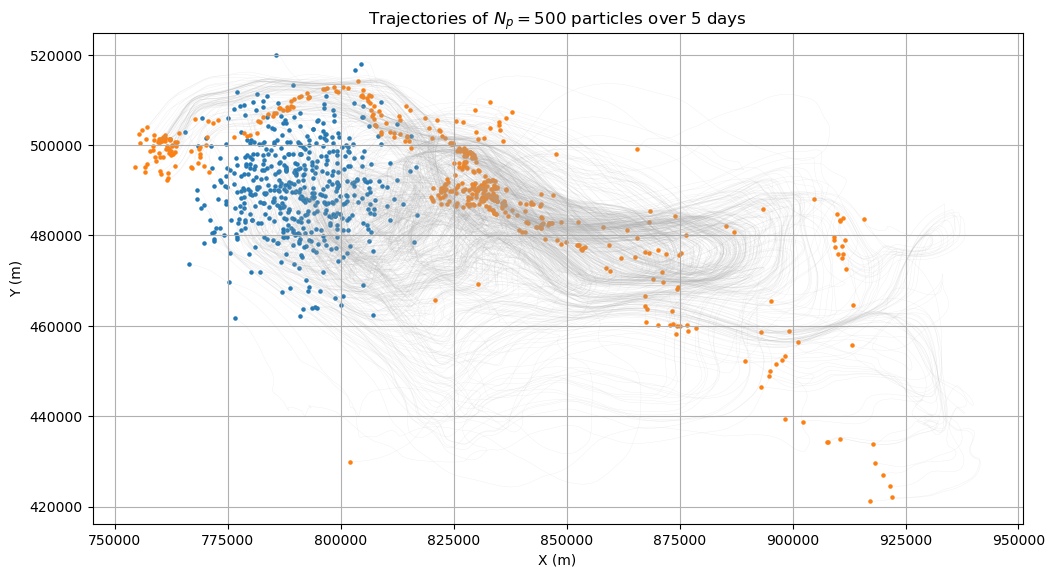

In [18]:
d = xr.open_dataset("data/NorKyst-800m.nc")
f= Interpolator(dataset=d)
fig_params = {"figsize": (7.5, 5)}
streamplot_params = {
    "color": "seagreen",
    "density": 1,
    "linewidth": 0.25,
    "arrowsize": 1,
    "arrowstyle": "->",
}
scatter_params = {"s": 5}
plot_params = {"alpha":0.2,"linewidth":0.25} #"color":"darkgray"}

Np=500
days = 5
T=[0, days * 24 * 3600]
dt=3600
mode="map"
loc=[790000, 490000]
scale=10000

traj = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale)
traj(f)
fig, ax = plt.subplots(1,1, figsize=(12, 8))
traj.plot(ax, **plot_params)
traj.scatter(ax, t=0,label='initial position', **scatter_params)
traj.scatter(ax, t=-1,label='final position', **scatter_params)
ax.set_title(f"Trajectories of $N_p = {Np}$ particles over {days} days")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
plt.grid(True)
plt.show()

## ( 2-b )

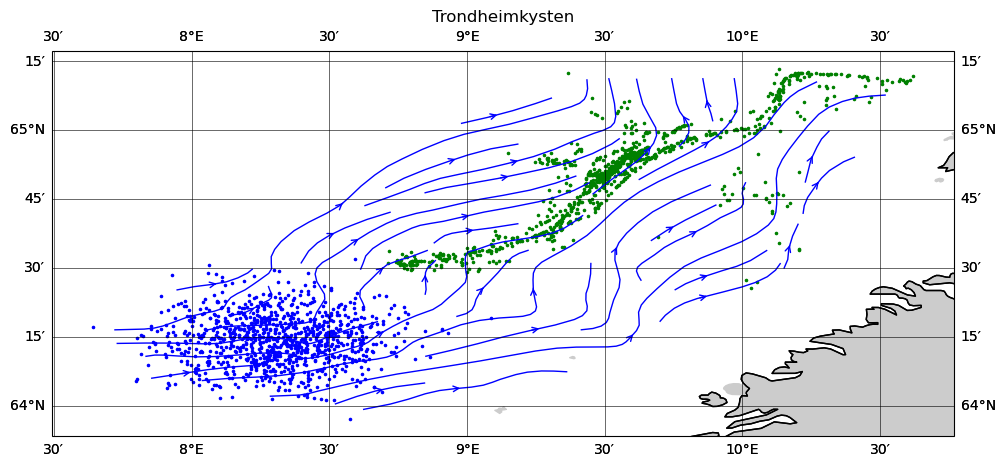

In [11]:
streamplot_params = {
    "color": "blue",
    "density": 1,
    "linewidth": 1,
    "arrowsize": 1,
    "arrowstyle": "->",
}
plot_params = {"linewidth": 0, "alpha": 0}
fig_params = {"figsize": (15, 8)}

Np=1000
days = 3
T = [0, days * 24 * 3600]
dt=3600
mode = "map"
loc, scale =[790000, 490000], 10000

fig, ax = plt.subplots(1,1,figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
traj_midt = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale)
traj_midt(f)
traj_midt.init_map(ax, **plot_params)
traj_midt.streamplot(ax, **streamplot_params)
traj_midt.scatter(ax, t=0, **{"label": "Initial Position", "color":"blue", "s": 2.5})
traj_midt.scatter(ax, t=-1, **{"label": "Final Position", "color": "green", "s": 2.5})
ax.set_title("Trondheimkysten")
plt.show()

# Problem 3

## ( 3-a )


In [12]:
streamplot_params = {
    "color": "seagreen",
    "density": 0.5,
    "linewidth": 1,
    "arrowsize": 1,
    "arrowstyle": "->",
}
plot_params = {
    "color": "cornflowerblue",
    "alpha" : 0.5,
    "linewidth": 0.1
}

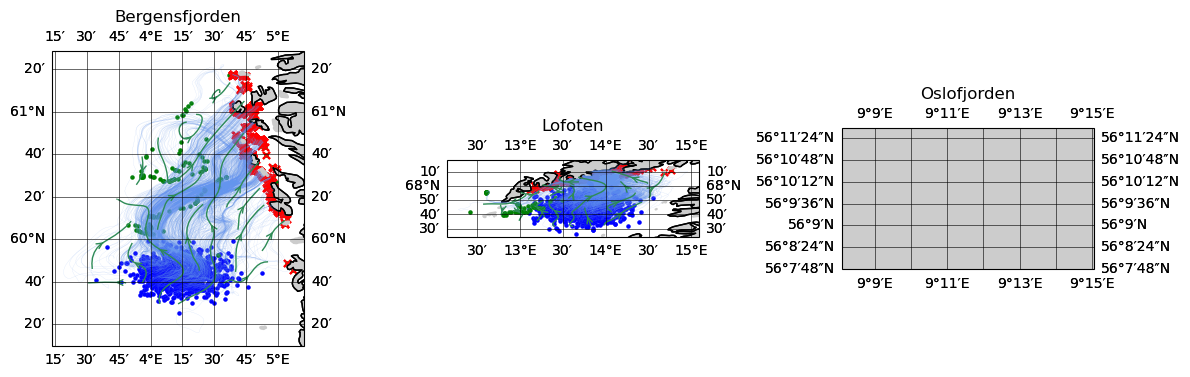

In [13]:
d = xr.open_dataset("data/NorKyst-800m.nc")
f = Interpolator(dataset=d)

Np=1000
days = 5
T = [0, days * 24 * 3600]
dt=3600
mode = "map"
loc, scale = [250000, 460000], 10000

fig, ax = plt.subplots(1,3,figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})
traj_bergen = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale, check_land=True)
traj_bergen(f)
traj_bergen.init_map(ax[0], **plot_params)
traj_bergen.streamplot(ax[0], **streamplot_params)
traj_bergen.scatter(ax[0], t=0, **{"label": "Initial Position", "color": "blue", "s": 5})
traj_bergen.scatter(ax[0], t=-1, **{"label": "Final Position", "color": "green", "s": 5})
ax[0].set_title("Bergensfjorden")

loc, scale = [1240000, 480000], 10000
traj_lofoten = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale, check_land=True)
traj_lofoten(f)
traj_lofoten.init_map(ax[1], **plot_params)
traj_lofoten.streamplot(ax[1], **streamplot_params)
traj_lofoten.scatter(ax[1], t=0, **{"label": "Initial Position", "color": "blue", "s": 5})
traj_lofoten.scatter(ax[1], t=-1, **{"label": "Final Position", "color": "green", "s": 5})
ax[1].set_title("Lofoten")

loc, scale = [25000, 14000], 1000
traj_oslo = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale, check_land=True)
traj_oslo(f)
traj_oslo.init_map(ax[2], **plot_params)
traj_oslo.streamplot(ax[2], **streamplot_params)
traj_oslo.scatter(ax[2], t=0, **{"label": "Initial Position", "color": "blue", "s": 5})
traj_oslo.scatter(ax[2], t=-1, **{"label": "Final Position", "color": "green", "s": 5})
ax[2].set_title("Oslofjorden")
plt.tight_layout()
plt.show()

## ( 3-b ) Windage factor

With the same initial conditions as above, try a few different windage factors, in
the range from 0 to 0.15, and show how this affects the results. You can for example
look into the percentage of particles that become stranded after three days as a
function of fw. Note that the results may of course depend on where (and when)
you start the particle trajectories, and for some initial conditions no particles will
reach land at all


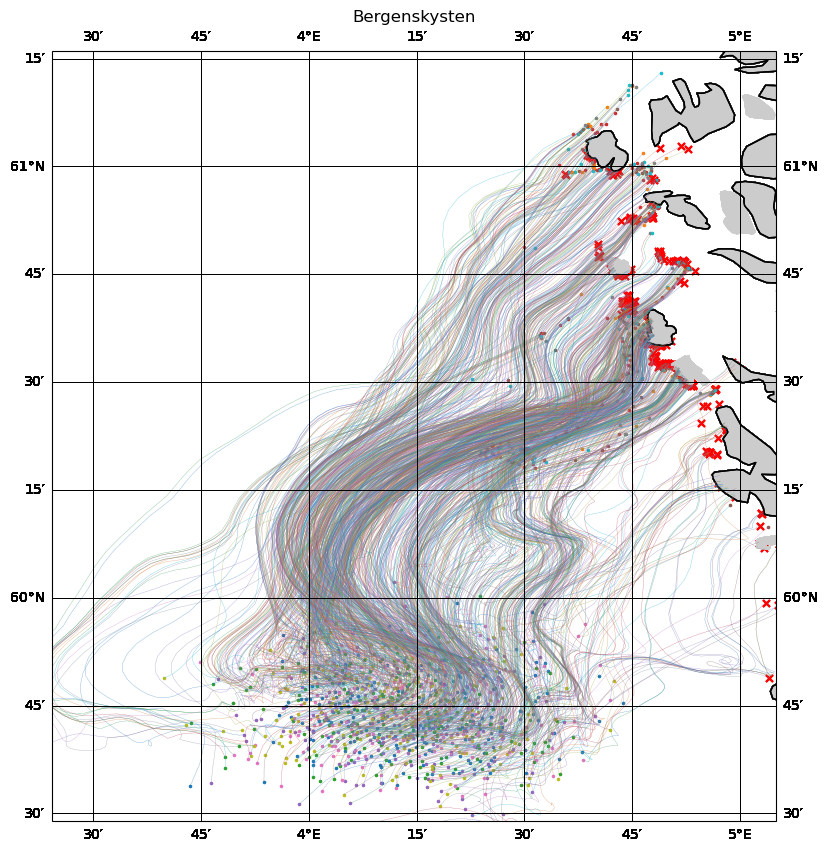

In [14]:
fw = np.linspace(0, 0.30, 10)

Np=100
days = 3
T = [0, days * 24 * 3600]
dt=3600
mode = "map"
loc, scale = [250000, 460000], 10000
fig, ax = plt.subplots(1,1,figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})

landed = []
for w in fw:
    d = xr.open_dataset("data/NorKyst-800m.nc")
    f = Interpolator(dataset=d)
    traj_bergen = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale, check_land=True)
    traj_bergen(f)
    traj_bergen.init_map(ax, **plot_params)
    traj_bergen.plot(ax, **{"alpha":0.5, "lw":0.25})
    traj_bergen.scatter(ax, t=0, **{"label": "Initial Position","s":2.5})
    traj_bergen.scatter(ax, t=-1, **{"label": "Final Position", "s":2.5})
    landed.append(traj_bergen.get_land_particles())


ax.set_title("Bergenskysten")
plt.show()

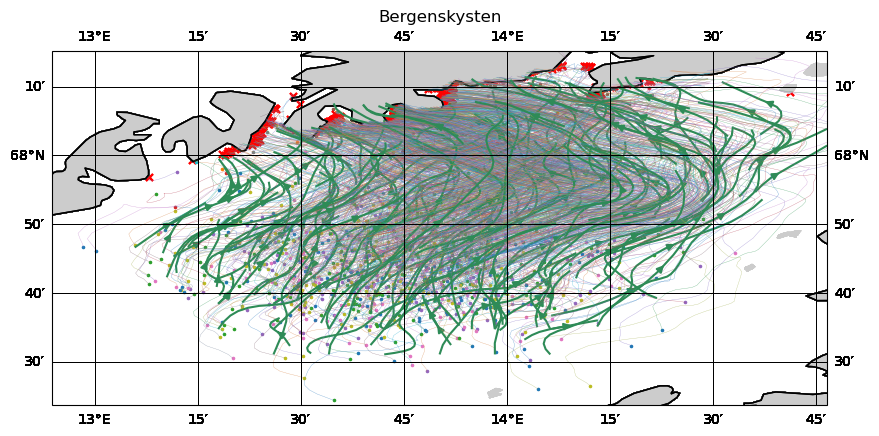

In [15]:
fw = np.linspace(0, 0.30, 10)
streamplot_params = {"density":0.5, "color":"seagreen",}
Np=100
days = 3
T = [0, days * 24 * 3600]
dt=3600
mode = "map"
loc, scale = [1240000, 480000], 10000
fig, ax = plt.subplots(1,1,figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})

landed = []
for w in fw:
    d = xr.open_dataset("data/NorKyst-800m.nc")
    f = Interpolator(dataset=d)
    traj_bergen = Trajectory(T=T, dt=dt, Np=Np, mode=mode, loc=loc, scale=scale, check_land=True)
    traj_bergen(f)
    traj_bergen.init_map(ax, **plot_params)
    traj_bergen.plot(ax, **{"alpha":0.5, "lw":0.25})
    traj_bergen.scatter(ax, t=0, **{"label": "Initial Position","s":2.5})
    traj_bergen.scatter(ax, t=-1, **{"label": "Final Position", "s":2.5})
    traj_bergen.streamplot(ax, **streamplot_params)
    landed.append(traj_bergen.get_land_particles())


ax.set_title("Bergenskysten")
plt.show()

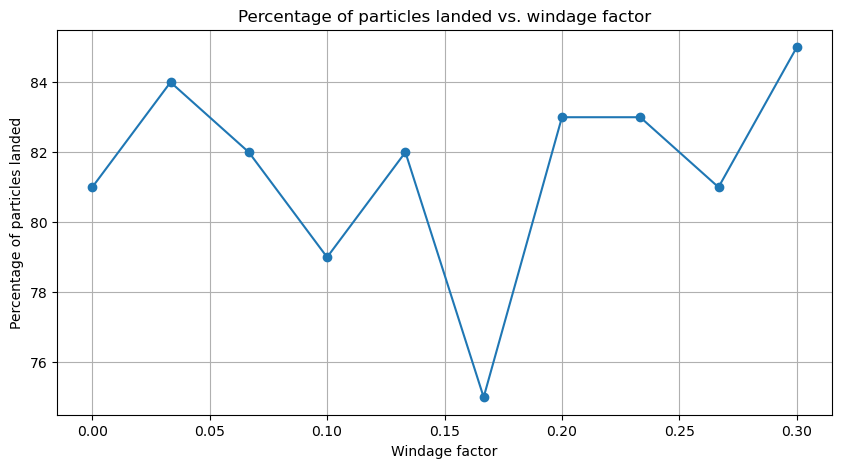

In [16]:

def get_landed_total(landed):
    coast = []
    for x,y in landed:
        coast.append(x.shape[0])
    coast = np.array(coast)
    return coast

coast = get_landed_total(landed)

fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.plot(fw, coast, marker="o")
ax.set_xlabel("Windage factor")
ax.set_ylabel("Percentage of particles landed")
ax.set_title("Percentage of particles landed vs. windage factor")
plt.grid()
plt.show()